In [1]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *
#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
from scipy.special import erfinv
import sympy as sym
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter

print(cf.base_directory)
from cmath import nan
import h5py    


user_settings = getattr(cf.plot_settings, 'settings')


../results/HEISENBERG/local_pert/OBC/


In [7]:
def page(L, f):    
    return f * L * np.log(2) - binom(2 * f * L, f * L) / binom(L, L/2) / 2

def Srand(L, f): 
    return page(L, f) + (f + np.log(1-f)) / 2. 

0.1 0 -1 (201, 6918)
0.1 0 1 (201, 7686)
0.1 9 -1 (201, 7400)
0.1 9 1 (201, 7144)
0.5339790795593702 1.5753877385701964

0.2 0 -1 (201, 6918)
0.2 0 1 (201, 7686)
0.2 9 -1 (201, 7400)
0.2 9 1 (201, 7144)
0.52463917588763 1.5750743162759926

0.3 0 -1 (201, 6918)
0.3 0 1 (201, 7686)
0.3 9 -1 (201, 7400)
0.3 9 1 (201, 7144)
0.5340095804507543 1.5757929940491904

0.4 0 -1 (201, 6918)
0.4 0 1 (201, 7686)
0.4 9 -1 (201, 7400)
0.4 9 1 (201, 7144)
0.5338744033041116 1.5770230007347716

0.5 0 -1 (201, 6918)
0.5 0 1 (201, 7686)
0.5 9 -1 (201, 7400)
0.5 9 1 (201, 7144)
0.5319368044599506 1.5787426497915553

0.6 0 -1 (201, 6918)
0.6 0 1 (201, 7686)
0.6 9 -1 (201, 7400)
0.6 9 1 (201, 7144)
0.5338563286522828 1.5802976452335848

0.7 0 -1 (201, 6918)
0.7 0 1 (201, 7686)
0.7 9 -1 (201, 7400)
0.7 9 1 (201, 7144)
0.5296553197691031 1.5838212478642713

0.8 0 -1 (201, 6918)
0.8 0 1 (201, 7686)
0.8 9 -1 (201, 7400)
0.8 9 1 (201, 7144)
0.5287610120091258 1.5880016698800896

0.9 0 -1 (201, 6918)
0.9 0 1 (201,

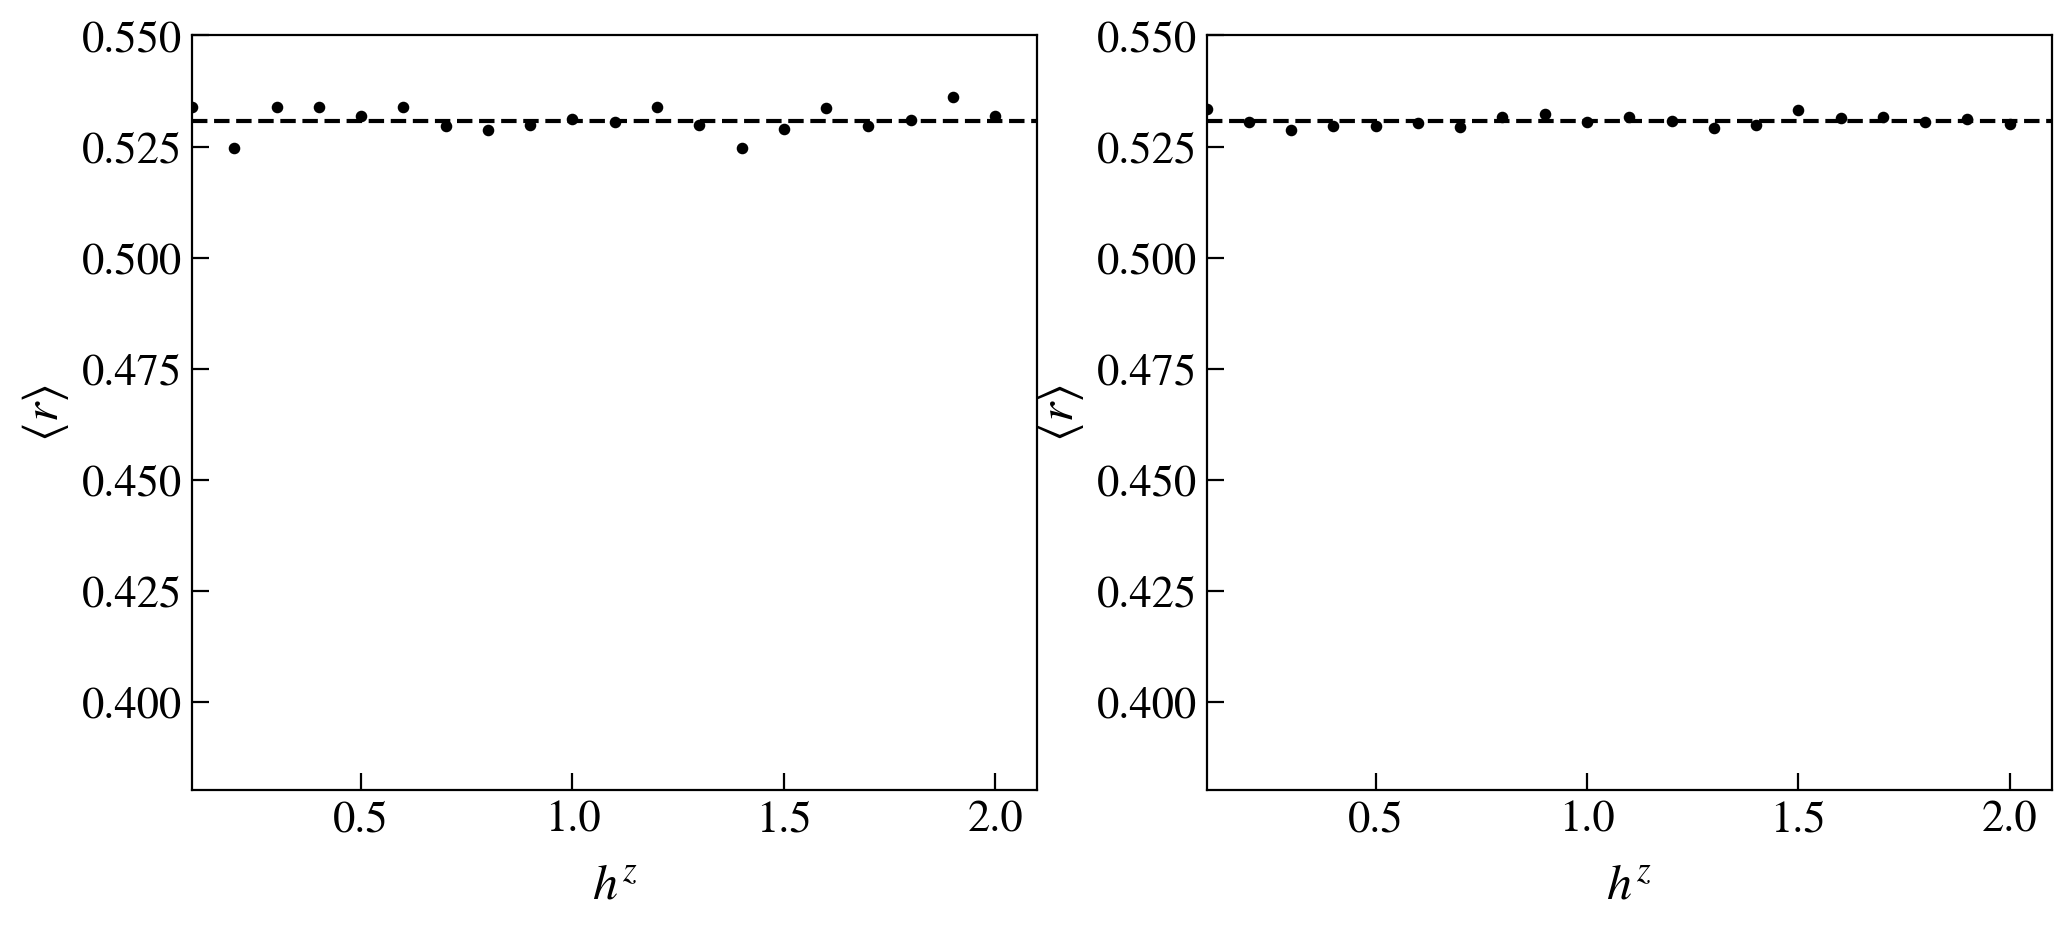

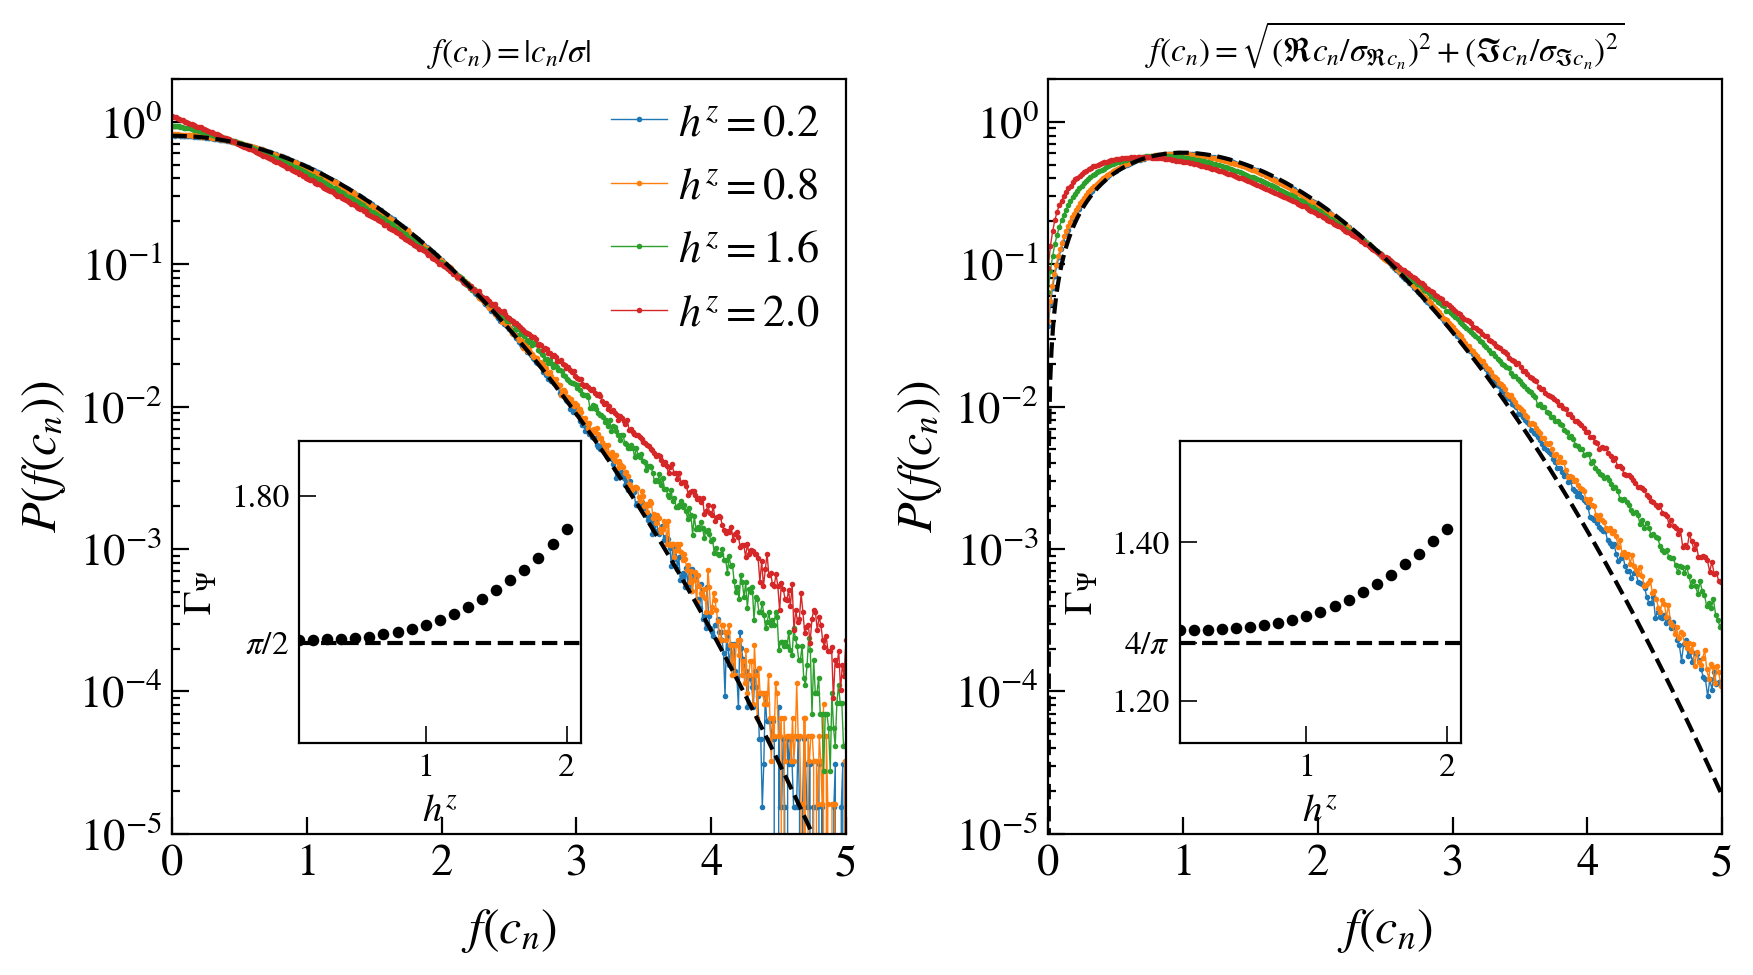

In [3]:
reload_modules()

fig, ax_gaps = plt.subplots( nrows=1, ncols=2, figsize=(12,5), dpi = 200)
fig_dist, ax_dist = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

width = 0.4
height = 0.4
ax_inset = [None, None]
for i, ax in enumerate(ax_dist):
    ax_inset[i] = hfun.add_subplot_axes(ax, [0.18 + 0.05 * i, 0.12, width, height])

L=18
J=2.0
J0=0.5
g=0.3
g0=0.3
h=0.2
w=0.1
k=1
p=1
x=1
if h > 0: x=1
use_Sz_sym = False
SYMMETRIES = True
dir = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/"

if use_Sz_sym:
    J0=0.0
    g0=0.0
    h=0.0
    if SYMMETRIES: g = 0
f = 1/2.

h_plot = [0.2, 0.8, 1.6, 2.0]
h_range = hfun.regspace(0.1, 2.1, 0.1)
h_found = []

real_sectors = [[0, -1], [0, 1], [L // 2, -1], [L // 2, 1]]
imag_sectors = 2 * [[kx, 1] for kx in range(1, L // 2)]
all_sectors = real_sectors + imag_sectors
use_real_sectors = 1



#real_sectors = [[0, p]]
#imag_sectors = [[1, p]]

def plotter(which):
    #use_real_sectors = 1 - use_real_sectors

    ax_all = [ax_gaps[which], ax_inset[which], ax_dist[which]]
    sectors = real_sectors if which == 0 else imag_sectors
    gap_ratio = []
    gauss = []
    for hx in h_range:
        wx = hx/2
        Smean_ener = []
        Smax = []
        validL = []
        colors_inset = {
            14: 'blue', 
            16: 'orange', 
            18: 'green', 
            20: 'red'
            }
        def get_data(ksym, psym, xsym = 1):
            info = hfun.info_sym(L, J, g, hx, ksym, psym, xsym) if SYMMETRIES else hfun.info_dis(L, J, J0, g, g0, hx, wx)
            info = dir + info[0 : info.index('.dat') :]

            filename = info + "_subsize=%d.hdf5"%(f * L)
            if exists(filename) and abs(int(f * L) - f * L) < 0.01:
                data = []
                if hx not in h_found: h_found.append(hx)
                with h5py.File(filename, "r") as file:
                    # Print all root level object names (aka keys) 
                    # these can be group or dataset names 
                    #print(info, "Keys: %s" % file.keys())
                    energies = np.array(file.get('energies')[0])
                    entropy = np.array(file.get('entropy')[0])
                    dim = energies.size

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))

                    if len(file.keys()) > 2: 
                        Vfull = np.array(file.get('eigenvectors')).view('complex')
                        #if [ksym, psym] == sectors[0]: 
                        print(hx, ksym, psym, Vfull.shape)
                        Vfull = Vfull.flatten()
                        
                        Vre = (Vfull).real# * np.sqrt(energies.size)
                        Vim = (Vfull).imag# * np.sqrt(energies.size)
                        #gaussianity = np.mean(np.square(np.abs(Vre))) / np.mean(np.abs(Vre))**2 - np.pi / 2.
                        #print(ksym, psym, "gaussianity = ", f"%.4e"%gaussianity)

                        V = (Vre - np.mean(Vre))**2. / np.var(Vre)
                        if any(Vim > 1e-10):
                            V += (Vim - np.mean(Vim))**2. / np.var(Vim)
                        V = np.sqrt(V)

                return True, energies, entropy, V
            else:
                print(filename)
                return False, np.array([]), np.array([]), np.array([])

        coeffs = np.array([])
        S = 0
        r = 0
        cunt = 0
        for [kk, px] in sectors:
            status, energies, entropy, V = get_data(ksym = kk, psym = px)
            if status:
                coeffs = np.concatenate((coeffs, V))
                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                size = energies.size
                
                num = 500 if L > 8 else 100
                #num = 0.5 * size
                my_min = int(index_meanE - num / 2);    
                if my_min < 0: my_min = 0

                my_max = int(index_meanE + num / 2);    
                if my_max>= size: my_max = size

                sample = entropy[my_min : my_max]
                S += energies.size / 2**L * np.mean(sample)

                gaps = np.diff(energies)
                gap_ratio = 0
                counter = 0
                for i in range(int(int(index_meanE - 0.5*size / 2)), int(int(index_meanE + 0.5*size / 2))):
                    gap_ratio += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                    counter += 1
                r += gap_ratio / counter

                cunt+=1
            else:
                print("Not Found")
        
        coeffs = np.array(coeffs)
        if hx in h_plot:
            hist, edge = np.histogram(coeffs, bins=500, normed=True)
            ax_dist[which].plot(edge[:-1], hist, marker='o', markersize=1, linewidth=0.5, label=r"$h^z=%.1f$"%hx)

        coeffs = np.abs(coeffs)
        gaussianity = np.mean(np.square(coeffs)) / np.mean(coeffs)**2

        r /= cunt
        print(r, gaussianity)
        print("")
        ax_gaps[which].scatter(hx, r, color='black', s=10)
        ax_inset[which].scatter(hx, gaussianity, color='black', s=10)



    hfun.set_plot_elements(axis = ax_gaps[which], ylabel = "\\langle r\\rangle", xlabel = "h^z", settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))

    fun_lab = r"$f(c_n)=|c_n/\sigma|$" if which == 0 else r"$f(c_n)=\sqrt{\left(\Re{c_n}/\sigma_{\Re{c_n}}\right)^2 + \left(\Im{c_n}/\sigma_{\Im{c_n}}\right)^2}$"
    ax_dist[which].set_title(fun_lab)
    hfun.set_plot_elements(axis = ax_dist[which], ylabel = "P(f(c_n))", xlabel = "f(c_n)", settings=user_settings, 
                                font_size=16, set_legend=False, xlim=(None, None), ylim=(None, None))
    if which == 0:
        ax_dist[which].legend(loc = 'upper right', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02, 1.02))

    hfun.set_plot_elements(axis = ax_inset[which], ylabel = "\\Gamma_\\Psi", xlabel = "h^z", settings=user_settings, 
                            font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    #ax_inset[which].legend(fontsize=12, loc='lower right', ncol=2, handletextpad=0.15, handlelength = 1.)


    for ax in list(ax_all):
        ax.set_xlim(0.0, 0.15)
        ax.set_xscale('linear')    
        ax.set_yscale('linear')
        ax.tick_params(axis="both",which='major',direction="in",length=6)
        ax.tick_params(axis="both",which='minor',direction="in",length=3)

        ax.set_xlim(0.1, 2.1)
    ax_all[0].set_ylim(0.38, 0.55)
    ax_all[0].axhline(y=0.5307, ls='--', color='black')

    ax_all[1].set_xlim(0.1, 2.1)
    val = np.pi / 2 if which == 0 else 4. / np.pi

    ax_all[1].set_ylim(0.8 * val, 1.2 * val)
    valname = r"$\pi/2$" if which == 0 else r"$4/\pi$"
    ax_all[1].axhline(y=val, ls='--', color='black')
    ax_all[1].set_yticks(list([tic for tic in ax_all[1].get_yticks() if np.abs(tic-val) > 0.05]) + [val]);   ytik = ax_all[1].get_yticks();
    tick_labels = ["%.2f"%ytic if ytic != val else valname for ytic in ax_all[1].get_yticks()]

    ax_all[1].set_yticklabels(tick_labels)
    ax_all[1].set_ylim(0.9 * val, 1.2 * val)



    ax_all[2].set_xscale('linear')
    ax_all[2].set_yscale('log')
    aa = np.linspace(-100.0, 100, 20000)
    mu=0.0
    sigma=1.
    ax_all[2].set_ylim(1e-5, 2.0)
    ax_all[2].set_xlim(0, 5)
    if which == 0:    
        ax_all[2].plot(aa, 2. / np.sqrt(2*np.pi) * np.exp( - (aa)**2 / (2)), linestyle='--', color='black')
        #ax_all[2].plot(aa, np.exp( -aa), linestyle='--', color='red')
    else:             
        ax_all[2].plot(aa, aa * np.exp( - aa**2 / (2)), linestyle='--', color='black')

    
    #ax_all[2].annotate(r"$h^z=%.1f,%.1f,...,%.1f$"%(min(h_found), h_found[1], max(h_found)), xy=(1, 0.2), xytext=(4.5, 0.3), va='top', ha='right',
    #            arrowprops={'arrowstyle': '->', 'connectionstyle': 'angle3,angleA=0,angleB=55'}, fontsize=14)
    fig_dist.subplots_adjust(wspace=0.3, hspace=0.3)

plotter(0)
plotter(1)

In [8]:
reload_modules()

L=18
J=2.0
J0=0.5
g=0.3
g0=0.3
h=0.2
w=0.1
k=0
p=1
x=1
if h > 0: x=1
use_Sz_sym = False

dir = "../results/XYZ/symmetries/PBC/Entropy/Eigenstate/"

if use_Sz_sym:
    J0=0.0
    g0=0.0
    h=0.0
    if SYMMETRIES: g = 0
f = 1/2.

h_plot = [0.2, 0.6, 0.8, 1.0, 1.2, 1.6, 2.0]

h_range = hfun.regspace(0.1, 2.2, 0.1)
J_range = hfun.regspace(0.1, 2.2, 0.1)

num_of_bins = 500

real_sectors = [[0, -1], [0, 1], [L // 2, -1], [L // 2, 1]]
imag_sectors = 2 * [[kx, 1] for kx in range(1, L // 2)]
all_sectors = real_sectors + imag_sectors
use_real_sectors = 1



real_sectors = [[k, p]]
imag_sectors = [[k, p]]



gap_ratio = []
gaussianity = []
ent = []
ent_max = []
for hx in h_range[:-1]:
    ratio = []
    gauss = []
    maxS = []
    meanS = []

    for Jx in J_range[:-1]:

        def get_data(ksym, psym, xsym = 1):
            info = hfun.info_sym(L, Jx, g, hx, ksym, psym, xsym)
            info = dir + info[0 : info.index('.dat') :]

            filename = info + "_subsize=%d.hdf5"%(f * L)
            if exists(filename):  
                data = []
                with h5py.File(filename, "r") as file:
                    # Print all root level object names (aka keys) 
                    # these can be group or dataset names 
                    #print(info, "Keys: %s" % file.keys())
                    energies = np.array(file.get('energies')[0])
                    entropy = np.array(file.get('entropy')[0])
                    dim = energies.size

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))

                    if len(file.keys()) > 2: 
                        Vfull = np.array(file.get('eigenvectors')).view('complex')
                        print(Jx, hx, ksym, psym, Vfull.shape)
                        Vfull = Vfull.flatten()
                        
                        V = (Vfull).real * np.sqrt(energies.size)
                        #Vim = (Vfull).imag * np.sqrt(energies.size)
                        #if any(np.abs(Vim) > 1e-9):
                        #    V = np.concatenate((V, Vim))
                        #V /= np.sqrt(np.var(V) - np.mean(V)**2)
                return True, energies, entropy, V
            else:
                print(filename)
                return False, np.array([]), np.array([]), np.array([])

        coeffs = np.array([])
        S = 0
        Smax_tmp = 0
        r = 0
        cunt = 0
        dims_tot = 0
        for [kk, px] in (real_sectors if use_real_sectors else imag_sectors):
            status, energies, entropy, V = get_data(ksym = kk, psym = px)
            if status:
                coeffs = np.concatenate((coeffs, V))
                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                size = energies.size
                
                num = 500 if L > 8 else 100
                #num = 0.5 * size
                my_min = int(index_meanE - num / 2);
                if my_min < 0: my_min = 0

                my_max = int(index_meanE + num / 2);    
                if my_max>= size: my_max = size

                if max(entropy) > Smax_tmp: Smax_tmp = max(entropy)
                sample = entropy[my_min : my_max]

                dims_tot += energies.size
                S += energies.size * np.mean(sample)
                #S += np.mean(sample)

                gaps = np.diff(energies)
                r_tmp = 0
                counter = 0
                for i in range(int(int(index_meanE - 0.5 * size / 2)), int(int(index_meanE + 0.5 * size / 2))):
                    r_tmp += min(gaps[i], gaps[i + 1]) / max(gaps[i], gaps[i + 1])
                    counter += 1
                r += r_tmp / counter

                cunt += 1
            #else: print("Not Found :( ")

        coeffs = np.abs(np.array(coeffs))
        gauss.append(np.mean(np.square(coeffs)) / np.mean(coeffs)**2 - np.pi / 2. if cunt > 0 else np.nan)

        ratio.append(r / cunt if cunt > 0 else np.nan)
        maxS.append(page(L, f) -  Smax_tmp if cunt > 0 else np.nan)
        meanS.append(page(L, f) -  S / dims_tot if cunt > 0 else np.nan)

    gap_ratio.append(np.array(ratio))
    gaussianity.append(np.array(gauss))
    ent.append(np.array(meanS))
    ent_max.append(np.array(maxS))

0.1 0.1 0 1 (201, 7686)
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.20,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.30,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.40,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
0.5 0.1 0 1 (201, 7686)
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.60,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.70,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.80,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=0.90,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=1.00,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries/PBC/Entropy/Eigenstate/_L=18,J=1.10,g=0.30,h=0.10,k=0,p=1,x=1_subsize=9.hdf5
../results/XYZ/symmetries

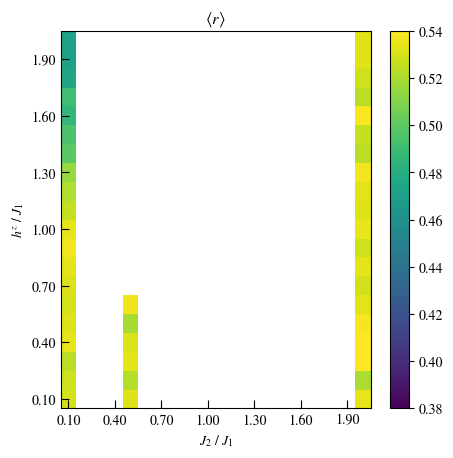

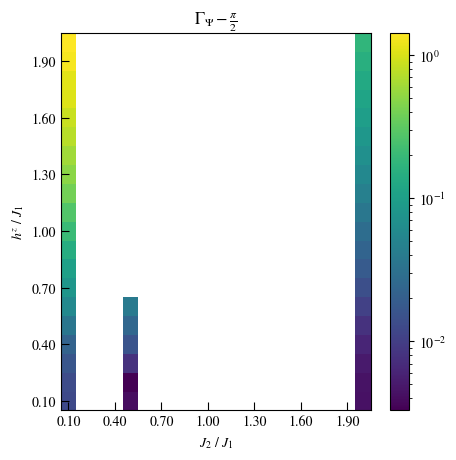

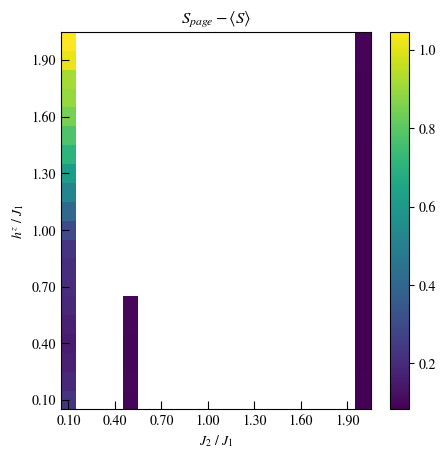

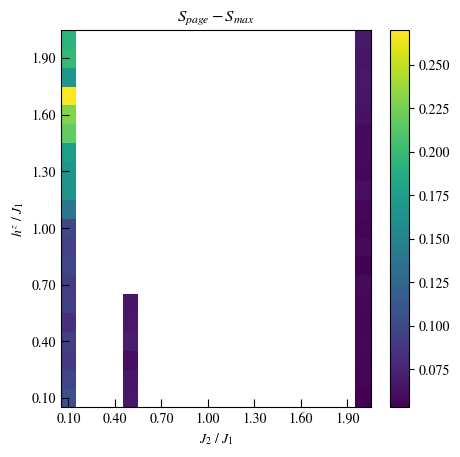

In [9]:

skipX = int(J_range.size / 6)
skipY = int(h_range.size / 6)

X, Y = np.meshgrid(J_range, h_range)

fig, ax_gaps = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gaps.pcolormesh(X, Y, gap_ratio, shading='flat', vmin=0.38, vmax=0.54)
ax_gaps.set_title(r"$\langle r\rangle$")
fig.colorbar(p)

fig, ax_gauss = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_gauss.pcolormesh(X, Y, gaussianity, shading='flat', norm=matplotlib.colors.LogNorm())
ax_gauss.set_title(r"$\Gamma_\Psi - \frac{\pi}{2}$")
fig.colorbar(p)

fig, ax_ent = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_ent.pcolormesh(X, Y, ent, shading='flat')
ax_ent.set_title(r"$S_{page} - \langle S\rangle$")
fig.colorbar(p)

fig, ax_outlier = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
p = ax_outlier.pcolormesh(X, Y, ent_max, shading='flat')
ax_outlier.set_title(r"$S_{page} - S_{max}$")
fig.colorbar(p)


for ax in [ax_gaps, ax_gauss, ax_ent, ax_outlier]:
    ax.set_xlabel(r"$J_2\ /\ J_1$")
    ax.set_ylabel(r"$h^z\ /\ J_1$")
    
    ax.set_yticks(h_range[:-1:skipY] + h_range[1] / 4.)
    ax.set_xticks(J_range[:-1:skipX] + J_range[1] / 4.)
    ax.set_xticklabels(["%.2f"%x for x in J_range[:-1:skipX]])
    ax.set_yticklabels(["%.2f"%x for x in h_range[:-1:skipY]])
    ax.tick_params(axis="both",which='major',direction="in",length=6)
    ax.tick_params(axis="both",which='minor',direction="in",length=3)

    maxX = max(J_range)
    maxY = max(h_range)
    ax.set_xlim(min(J_range), maxX)
    ax.set_ylim(min(h_range), maxY)